In [10]:
# NOTES AND COMMENTS

""" 
- The model calculates and gives predictions
- I tested it giving it 1 days to predict the next 2 days
- In that case it calculates for about 10 minutes on my computer
- To manipulate the number of days in training/testing set you should edit the "Data - train" sheet in excel file model_data.xlsx
- Just delete the rows you don't want to use
- The model is not perfect but it is a good start
- What we can do further?
    a) Now I hardcoded which attributes are forecasts and which are actuals (we could automatize this)
    b) We could add one more attribte - the snowfall - to the model (to consider) ?
    e) To speed up the model we could use the GPU (to investigate is it possible to use GPU for this model) ?
    f) PCA to reduce the number of attributes (with more attributes)
    h) Corelation matrix + heatmap
- I think we can ask the teachers about some of the above 
- But I also think that in the issues relatec to coding they won't be able to helps us 
- Maybe just give general advice
"""

' \n- The model calculates and gives predictions\n- I tested it giving it 1 days to predict the next 2 days\n- In that case it calculates for about 10 minutes on my computer\n- To manipulate the number of days in training/testing set you should edit the "Data - train" sheet in excel file model_data.xlsx\n- Just delete the rows you don\'t want to use\n- The model is not perfect but it is a good start\n- What we can do further?\n    a) Now I hardcoded which attributes are forecasts and which are actuals (we could automatize this)\n    b) We could add one more attribte - the snowfall - to the model (to consider) ?\n    e) To speed up the model we could use the GPU (to investigate is it possible to use GPU for this model) ?\n    f) PCA to reduce the number of attributes (with more attributes)\n    h) Corelation matrix + heatmap\n- I think we can ask the teachers about some of the above \n- But I also think that in the issues relatec to coding they won\'t be able to helps us \n- Maybe just 

In [11]:
# IMPORTS

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.infer import Predictive

import jax
import jax.numpy as jnp
from jax import random, jit, grad
from jax.example_libraries import stax
from jax.example_libraries.stax import Dense, Relu, FanOut, FanInConcat

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from itertools import combinations


In [12]:
# LOAD DATA FROM EXCEL FILE

# Load the Excel file into a pandas DataFrame
df = pd.read_excel('model_data.xlsx', sheet_name='Data - train')

# Initialize a dictionary to hold numpy arrays
numpy_arrays = {}

# Loop through each column and add to the dictionary
for column in df.columns:
    numpy_arrays[column] = df[column].to_numpy()

numpy_arrays.keys()  # This will display the keys which are the column names.

dict_keys(['year', 'month', 'day_of_month', 'day_of_week', 'hour_of_day', 'gen_total_forecast', 'gen_total_actual', 'gen_wind_forecast', 'gen_wind_actual', 'gen_solar_forecast', 'gen_solar_actual', 'load_total_forecast', 'load_total_actual', 'dah_price', 'dah_volume', 'temp_forecast', 'temp_actual', 'wind_speed_forecast', 'wind_speed_actual', 'solar_rad_forecast', 'solar_rad_actual', 'bm_price', 'bm_imbalance_volume'])

In [13]:
# CREATE MATRICES X AND Y WITH MODEL FEATURES AND TARGETS

# Create the matrix X with the specified columns
columns_for_X = [
    'year', 'month', 'day_of_month', 'day_of_week', 'hour_of_day',
    'gen_total_forecast', 'gen_total_actual', 'gen_wind_forecast', 'gen_wind_actual',
    'gen_solar_forecast', 'gen_solar_actual', 'load_total_forecast', 'load_total_actual',
    'dah_price', 'dah_volume', 'temp_forecast', 'temp_actual', 'wind_speed_forecast',
    'wind_speed_actual', 'solar_rad_forecast', 'solar_rad_actual'
]

# Create the matrix Y with the specified columns
columns_for_Y = ['bm_price', 'bm_imbalance_volume']

# Extract the matrices as NumPy arrays
X = df[columns_for_X].to_numpy()
Y = df[columns_for_Y].to_numpy()


# Indices for forecast and actual values
forecast_indices = [5, 7, 9, 11, 15, 17, 19]

# Print the first 15 rows of X
preview_X = df[columns_for_X].head(15)
print(preview_X)

    year  month  day_of_month  day_of_week  hour_of_day  gen_total_forecast  \
0   2023      1             1            1            1               16887   
1   2023      1             1            1            2               17697   
2   2023      1             1            1            3               16705   
3   2023      1             1            1            4               16162   
4   2023      1             1            1            5               16070   
5   2023      1             1            1            6               15982   
6   2023      1             1            1            7               15904   
7   2023      1             1            1            8               15866   
8   2023      1             1            1            9               16803   
9   2023      1             1            1           10               18254   
10  2023      1             1            1           11               19210   
11  2023      1             1            1          

In [14]:
# STANDARDIZE THE DATA

# StandardScaler for standardizing features
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

# Fit the scaler on the columns from the 6th to the end, excluding the first 5 columns (time features)
scaler_X.fit(X[:, 5:])

# Standardize the X matrix columns from the 6th to the end
X[:, 5:] = scaler_X.transform(X[:, 5:])

# Fit the scaler on the Y matrix and standardize it
scaler_Y.fit(Y)
Y = scaler_Y.transform(Y)



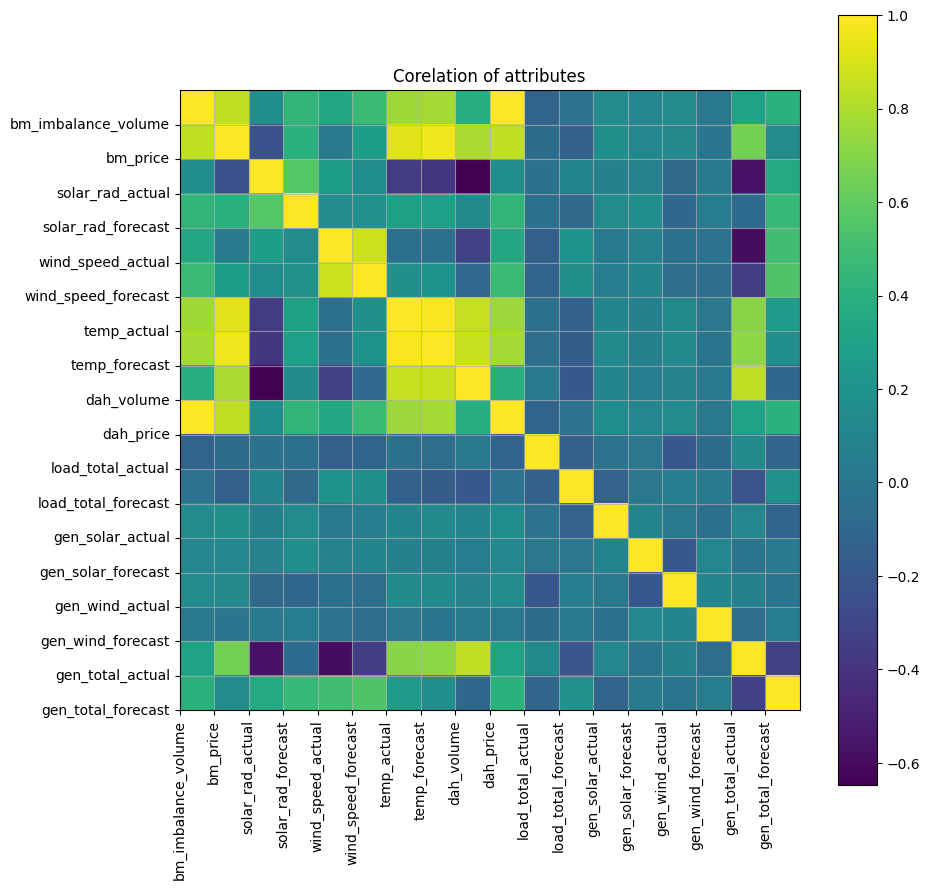

In [15]:
# CREATE THE CORRELATION MATRIX

# Calculate the correlation matrix
correlation_matrix = np.corrcoef(np.concatenate((X[:, 5:], Y), axis=1), rowvar=False)
attributeNames = np.concatenate((columns_for_X[5:], columns_for_Y))

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 10))  # Set the size of the figure
plt.imshow(correlation_matrix, cmap='viridis', origin='upper', extent=[0, 18, 0, 18])  # Plot the heatmap
plt.colorbar()  # Add a colorbar to the heatmap
plt.title('Corelation of attributes', fontsize=12)  # Add a title to the heatmap
plt.xticks(np.arange(len(attributeNames)), np.flip(attributeNames), rotation = 90, va='top', fontsize=10)
plt.yticks(np.arange(len(attributeNames)), attributeNames, va='center', fontsize=10)
plt.grid(True, linestyle='-', alpha=0.7)  # Add gridlines to the heatmap
plt.show()  # Show the heatmap

In [16]:
# Printing plots attribute vs attribute if their correlation is bigger than threshold:
Z = np.concatenate((X[:, 5:], Y), axis=1)
P, Q = Z.shape
corr_threshold = 0.85
plot_counter = 1
plt.figure(figsize=(100, 100))
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                        labelbottom=False, labelleft=False)
for i, atti in enumerate(attributeNames):
    for j, attj in enumerate(attributeNames):
        if i < j and correlation_matrix[i, j] >= corr_threshold and correlation_matrix[i, j] <= 0.99:
            plt.subplot(Q, Q, plot_counter)
            plt.scatter(Z[:, i], Z[:, j], s=3, alpha=1)
            plt.title(f'{atti} VS {attj}')  # Update the title
            plt.xlabel(atti)  # Update the X axis label
            plt.ylabel(attj)  # Update the Y axis label
            plt.text(0.7, 0.95, f'Corr: {correlation_matrix[i, j]:.2f}', transform=plt.gca().transAxes, fontsize=5, ha='left', va='top')
            plot_counter += 1
plt.subplots_adjust(hspace=0.5, wspace=0.5)

In [17]:
# SPLIT THE DATA INTO TRAINING AND TESTING SETS
# THE TEST SET WILL BE THE LAST 14 DAYS OF DATA
# THE TRAINING SET WILL BE THE REST

hours_in_14_days = 2 * 24  # Total hours in 14 days

# Find the indices for training and testing data
ix_train = np.arange(0, len(df) - hours_in_14_days)
ix_test = np.arange(len(df) - hours_in_14_days, len(df))

# Split the data
X_train = X[ix_train,:]
X_test = X[ix_test,:]
y_train = Y[ix_train]
y_test = Y[ix_test]


In [18]:
'''
# SPLIT THE DATA INTO TRAINING AND TESTING SETS
# THE TEST SET WILL BE THE LAST 24H OF DATA
# THE TRAINING SET WILL BE THE REST

# Find the indices for training and testing data
ix_train = np.arange(0, len(df) - 24)
ix_test = np.arange(len(df) - 24, len(df))

# Split the data
X_train = X[ix_train,:]
X_test = X[ix_test,:]
y_train = Y[ix_train]
y_test = Y[ix_test]
'''

'\n# SPLIT THE DATA INTO TRAINING AND TESTING SETS\n# THE TEST SET WILL BE THE LAST 24H OF DATA\n# THE TRAINING SET WILL BE THE REST\n\n# Find the indices for training and testing data\nix_train = np.arange(0, len(df) - 24)\nix_test = np.arange(len(df) - 24, len(df))\n\n# Split the data\nX_train = X[ix_train,:]\nX_test = X[ix_test,:]\ny_train = Y[ix_train]\ny_test = Y[ix_test]\n'

In [19]:
# MODEL THAT PREDICTS ACTUALS FROM FORECASTS

def forecasts_to_actuals_model(X, forecast_indices):

    # Number of pairs forecast-actual
    num_pairs = len(forecast_indices) 
    
    alphas = numpyro.sample('alphas', dist.Normal(0, 10).expand([num_pairs]))  # Alpha for each pair
    betas = numpyro.sample('betas', dist.Normal(0, 10).expand([num_pairs]))    # Beta for each pair
    sigmas = numpyro.sample('sigmas', dist.HalfNormal(10).expand([num_pairs])) # Sigma for each pair

    for i, f_idx in enumerate(forecast_indices):
        a_idx = f_idx + 1  # Actual index is forecast index + 1
        forecasts = X[:, f_idx]
        actuals = X[:, a_idx]
        
        # Mean of the normal distribution (linear model of forecast to actuals)
        mean = alphas[i] + betas[i] * forecasts
        numpyro.sample(f'obs_{i}', dist.Normal(mean, sigmas[i]), obs=actuals)


In [20]:
# BECAUSE WE DON'T HAVE HISTORICAL FORECASTS FOR MORE THAN 6 MONTHS THIS FUNCTION WILL FILTER OUT ROWS WHERE THERE ARE NO FORECASTS

def filter_complete_cases(X, forecast_indices):
    
    valid_rows = np.ones(len(X), dtype=bool)
    for f_idx in forecast_indices:
        a_idx = f_idx + 1
        valid_rows &= ~np.isnan(X[:, f_idx]) & ~np.isnan(X[:, a_idx])  # Keep the rows where both forecast and actual are not NaN

    return X[valid_rows]

In [21]:
# TRAIN THE FORECASTS TO ACTUALS MODEL

# Filter the data to train the model on cases where we have both forecasts and actuals
filtered_X_train = filter_complete_cases(X_train, forecast_indices)

# Compile the model
nuts_kernel = NUTS(forecasts_to_actuals_model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)
mcmc.run(random.PRNGKey(0), filtered_X_train, forecast_indices)

# Get the samples
mcmc_samples = mcmc.get_samples()

sample: 100%|██████████| 1500/1500 [00:10<00:00, 142.71it/s, 15 steps of size 2.98e-01. acc. prob=0.91]


In [22]:
# GET THE MEAN VALUES FROM THE MCMC SAMPLES

# Mean values of the parameters
alpha_mean = jnp.mean(mcmc_samples['alphas'], axis=0)
beta_mean = jnp.mean(mcmc_samples['betas'], axis=0)
sigma_mean = jnp.mean(mcmc_samples['sigmas'], axis=0)

In [23]:
# GENERATE PREDICTED ACTUALS FOR X_TEST

def generate_predicted_actuals(X_test, forecast_indices, alpha_mean, beta_mean):
    
    # Copy the X_test matrix to avoid modifying the original
    X_test_predicted = X_test.copy()
    
    # Loop through the forecast indices
    for i, f_idx in enumerate(forecast_indices):
        a_idx = f_idx + 1  # Indeks kolumny 'actual'
        forecasts = X_test[:, f_idx]
        
        # Calculate the predicted actuals
        predicted_actuals = alpha_mean[i] + beta_mean[i] * forecasts
        
        # Update the X_test_predicted matrix
        X_test_predicted[:, a_idx] = predicted_actuals
    
    return X_test_predicted

In [24]:
# Generate the predicted actuals for X_test and fill in the missing values
X_test = generate_predicted_actuals(X_test, forecast_indices, alpha_mean, beta_mean)

In [25]:
def fill_missing_forecasts(X, forecast_indices, alpha_mean, beta_mean):
    
    for i, f_idx in enumerate(forecast_indices):
        a_idx = f_idx + 1
        for j in range(X.shape[0]):
            # Check if the forecast is missing
            if np.isnan(X[j, f_idx]):
                if beta_mean[i] != 0:  # Don't divide by zero
                    # Calculate forecast from actual
                    X[j, f_idx] = (X[j, a_idx] - alpha_mean[i]) / beta_mean[i]
                else:
                    # If beta is zero, use the mean forecast
                    X[j, f_idx] = np.mean(X[~np.isnan(X[:, f_idx]), f_idx])
    return X

# Fill in the missing forecast values in X_train and X_test
X_train = fill_missing_forecasts(X_train, forecast_indices, alpha_mean, beta_mean)
X_test = fill_missing_forecasts(X_test, forecast_indices, alpha_mean, beta_mean)

In [26]:

# Initialization pf PCA 
pca = PCA(n_components=0.95)  # 95% of variance explained

# Fit the PCA model on the training data
X_train_pca = pca.fit_transform(X_train[:, 5:])

# Transform the test data
X_test_pca = pca.transform(X_test[:, 5:])

# Concatenate the PCA components with the original features
X_train = np.concatenate([X_train[:, :5], X_train_pca], axis=1)
X_test = np.concatenate([X_test[:, :5], X_test_pca], axis=1)

# Print the number of components
print(f"Number of components: {pca.n_components_}")


Number of components: 8


In [27]:
# HELPER FUNCTIONS FOR THE HMM MODEL

"""
def initialize_network_input(X, num_features, extra_features=2):
    # num_features is the number of features in X after PCA
    # extra_features is the number of additional features we will add (for example, for latent states or other inputs)

    # Initialize the input tensor with zeros
    initial_input = jnp.zeros((1, num_features + extra_features))

    # We put the entire X into the initial input tensor
    # Assuming X is a single sample with num_features coming from PCA
    initial_input = initial_input.at[0, :num_features].set(X[0, :])

    return initial_input

def prepare_input_features(S_price, S_volume, X, t, num_features):
    # Chaging the shape of the input features to (1, N) for the neural network
    S_price_vector = S_price[-1].reshape(1, -1)         # Make sure the shape is (1, N)
    S_volume_vector = S_volume[-1].reshape(1, -1)       # Make sure the shape is (1, N)
    
    # Reshape the features from X at time t, ensuring it matches the expected number of features after PCA
    X_vector = X[t, :num_features].reshape(1, -1)       # Reshape X features to (1, N), assuming X includes PCA transformed features

    # Concatenate the input features
    input_features = jnp.concatenate([S_price_vector, S_volume_vector, X_vector], axis=1)
    
    return input_features

# DNN that takes the input features + previous latent state and returns the new latent state
# This is the top DNN
def create_top_DNN():

    # Define the base network
    base_net = stax.serial(
        Dense(32), Relu,
        Dense(32), Relu,
        Dense(32), Relu
    )

    # Define the branches for the mean and standard deviation (price and volume)
    branch1 = stax.serial(Dense(1))  # Mean path for price
    branch2 = stax.serial(Dense(1))  # Mean path for volume

    # Combine the branches with the base network
    return stax.serial(
        base_net,
        FanOut(2),
        stax.parallel(branch1, branch2),
        FanInConcat()  # Concatenating all outputs into a single output layer
    )

# DNN that takes the latent state (S_price) and returns the forecast (BM Price)
def create_bottom_DNN_price():
    return stax.serial(
        Dense(9), Relu,
        Dense(9), Relu,
        Dense(3), Relu,
        Dense(1)  # Output layer 
    )

# DNN that takes the latent state (S_volume) and returns the forecast (BM Volume)
def create_bottom_DNN_volume():
    return stax.serial(
        Dense(9), Relu,
        Dense(9), Relu,
        Dense(3), Relu,
        Dense(1)  # Output layer 
    )
"""

'\ndef initialize_network_input(X, num_features, extra_features=2):\n    # num_features is the number of features in X after PCA\n    # extra_features is the number of additional features we will add (for example, for latent states or other inputs)\n\n    # Initialize the input tensor with zeros\n    initial_input = jnp.zeros((1, num_features + extra_features))\n\n    # We put the entire X into the initial input tensor\n    # Assuming X is a single sample with num_features coming from PCA\n    initial_input = initial_input.at[0, :num_features].set(X[0, :])\n\n    return initial_input\n\ndef prepare_input_features(S_price, S_volume, X, t, num_features):\n    # Chaging the shape of the input features to (1, N) for the neural network\n    S_price_vector = S_price[-1].reshape(1, -1)         # Make sure the shape is (1, N)\n    S_volume_vector = S_volume[-1].reshape(1, -1)       # Make sure the shape is (1, N)\n    \n    # Reshape the features from X at time t, ensuring it matches the expec

In [28]:
# HMM MODEL DEFINITION

def hmm_model(X, Y=None, is_training=True):
    num_time_steps, num_features = X.shape

    # Initializations of priors for linear regression
    beta_price = numpyro.sample('beta_price', dist.Normal(jnp.zeros(num_features + 1), jnp.ones(num_features + 1)))
    beta_volume = numpyro.sample('beta_volume', dist.Normal(jnp.zeros(num_features + 1), jnp.ones(num_features + 1)))
    intercept_price = numpyro.sample('intercept_price', dist.Normal(0, 1))
    intercept_volume = numpyro.sample('intercept_volume', dist.Normal(0, 1))

    # Priors for the standard deviations
    price_std = numpyro.sample('price_std', dist.HalfNormal(1))
    volume_std = numpyro.sample('volume_std', dist.HalfNormal(1))

    # Initialize the arrays to store the latent states and observations
    S_price = jnp.zeros(num_time_steps)
    S_volume = jnp.zeros(num_time_steps)
    Y_obs = jnp.zeros((num_time_steps, 2))

    # Loop through the time steps
    for t in range(num_time_steps):

        if t == 0:
            S_price_prev = 0
            S_volume_prev = 0
        else:
            S_price_prev = S_price[t-1]
            S_volume_prev = S_volume[t-1]

        # Linear regression to predict the latent state at time t basing on the previous latent state and the input features
        S_price_t = jnp.dot(jnp.append(X[t, :], S_price_prev), beta_price) + intercept_price
        S_volume_t = jnp.dot(jnp.append(X[t, :], S_volume_prev), beta_volume) + intercept_volume

        # Linear regression to predict the observations at time t basing on the latent state
        forecasted_price = numpyro.sample(f'price_{t}', dist.Normal(S_price_t, price_std), obs=Y[t, 0] if is_training and Y is not None and t < Y.shape[0] else None)
        forecasted_volume = numpyro.sample(f'volume_{t}', dist.Normal(S_volume_t, volume_std), obs=Y[t, 1] if is_training and Y is not None and t < Y.shape[0] else None)

        # Saving the results to the arrays
        S_price = S_price.at[t].set(S_price_t)
        S_volume = S_volume.at[t].set(S_volume_t)
        Y_obs = Y_obs.at[t].set(jnp.array([forecasted_price, forecasted_volume]))

    return Y_obs


In [29]:
# TRAIN THE MODEL

# Run the model with MCMC
is_training = True
nuts_kernel = NUTS(hmm_model)
mcmc = numpyro.infer.MCMC(nuts_kernel, num_warmup=500, num_samples=1000)
mcmc.run(jax.random.PRNGKey(0), X_train, y_train, is_training=is_training)

sample: 100%|██████████| 1500/1500 [00:22<00:00, 67.43it/s, 3 steps of size 3.26e-11. acc. prob=0.89] 


In [30]:
# MODEL SUMMARY

mcmc.print_summary()


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta_price[0]     -0.81      0.00     -0.81     -0.81     -0.81      0.50      1.00
     beta_price[1]     -0.98      0.00     -0.98     -0.98     -0.98      0.50      1.00
     beta_price[2]      0.60      0.00      0.60      0.60      0.60      0.50      1.00
     beta_price[3]     -0.77      0.00     -0.77     -0.77     -0.77      0.50      1.00
     beta_price[4]      1.95      0.00      1.95      1.95      1.95      0.50      1.00
     beta_price[5]     -0.69      0.00     -0.69     -0.69     -0.69      0.50      1.00
     beta_price[6]     -1.15      0.00     -1.15     -1.15     -1.15      0.50      1.00
     beta_price[7]     -0.64      0.00     -0.64     -0.64     -0.64      0.50      1.00
     beta_price[8]     -1.05      0.00     -1.05     -1.05     -1.05      0.50      1.00
     beta_price[9]      0.59      0.00      0.59      0.59      0.59      0.50      1.00
    beta_price[10]  

In [31]:
'''def generate_hourly_forecasts(X_test, hours_in_14_days, predictive_model, mcmc_samples):
    predictive = Predictive(model=predictive_model, posterior_samples=mcmc_samples)
    predicted_prices = []
    current_input = X_test[0].copy()

    for hour in range(hours_in_14_days):
        key = jax.random.PRNGKey(hour)
        predictions = predictive(key, X=current_input.reshape(1, -1))
        print(f"Available keys in predictions: {list(predictions.keys())}")

        if 'price_0' in predictions:
            print(f"Shape of price_0: {predictions['price_0'].shape}")
            print(f"Content of price_0: {predictions['price_0']}")

            # Check the dimension of price_0 and adjust indexing accordingly
            if predictions['price_0'].ndim > 1:
                current_price_prediction = predictions['price_0'][0][0]
            else:
                current_price_prediction = predictions['price_0'][0]

            predicted_prices.append(current_price_prediction)

            if hour + 1 < hours_in_14_days:
                next_input = X_test[hour + 1].copy()
                next_input[0] = current_price_prediction
                current_input = next_input
        else:
            print("Error: 'price_0' key not found in the predictions dictionary")
            break

    return predicted_prices'''


'def generate_hourly_forecasts(X_test, hours_in_14_days, predictive_model, mcmc_samples):\n    predictive = Predictive(model=predictive_model, posterior_samples=mcmc_samples)\n    predicted_prices = []\n    current_input = X_test[0].copy()\n\n    for hour in range(hours_in_14_days):\n        key = jax.random.PRNGKey(hour)\n        predictions = predictive(key, X=current_input.reshape(1, -1))\n        print(f"Available keys in predictions: {list(predictions.keys())}")\n\n        if \'price_0\' in predictions:\n            print(f"Shape of price_0: {predictions[\'price_0\'].shape}")\n            print(f"Content of price_0: {predictions[\'price_0\']}")\n\n            # Check the dimension of price_0 and adjust indexing accordingly\n            if predictions[\'price_0\'].ndim > 1:\n                current_price_prediction = predictions[\'price_0\'][0][0]\n            else:\n                current_price_prediction = predictions[\'price_0\'][0]\n\n            predicted_prices.append(curren

In [32]:
'''# get samples from MCMC
predicted_prices = generate_hourly_forecasts(X_test, hours_in_14_days, hmm_model, mcmc.get_samples())

# draw the comparison plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(predicted_prices, label='Predicted Prices')
ax.plot(y_test[:hours_in_14_days, 0], label='Actual Prices', linestyle='--')  
ax.set_title('Hourly Price Predictions vs Actuals for the Next 14 Days')
ax.legend()
plt.show()'''

"# get samples from MCMC\npredicted_prices = generate_hourly_forecasts(X_test, hours_in_14_days, hmm_model, mcmc.get_samples())\n\n# draw the comparison plot\nfig, ax = plt.subplots(figsize=(10, 6))\nax.plot(predicted_prices, label='Predicted Prices')\nax.plot(y_test[:hours_in_14_days, 0], label='Actual Prices', linestyle='--')  \nax.set_title('Hourly Price Predictions vs Actuals for the Next 14 Days')\nax.legend()\nplt.show()"

In [33]:
'''def generate_hourly_forecasts(X_test, hours_in_14_days, predictive_model, mcmc_samples):
    predictive = Predictive(model=predictive_model, posterior_samples=mcmc_samples)
    predicted_prices = []
    current_input = X_test[0].copy()

    for hour in range(hours_in_14_days):
        key = jax.random.PRNGKey(hour)
        predictions = predictive(key, X=current_input.reshape(1, -1))
        print(f"Available keys in predictions: {list(predictions.keys())}")

        if 'price_0' in predictions:
            print(f"Shape of price_0: {predictions['volume_0'].shape}")
            print(f"Content of price_0: {predictions['volume_0']}")

            # Check the dimension of price_0 and adjust indexing accordingly
            if predictions['price_0'].ndim > 1:
                current_price_prediction = predictions['volume_0'][0][0]
            else:
                current_price_prediction = predictions['volume_0'][0]

            predicted_prices.append(current_price_prediction)

            if hour + 1 < hours_in_14_days:
                next_input = X_test[hour + 1].copy()
                next_input[0] = current_price_prediction
                current_input = next_input
        else:
            print("Error: 'price_0' key not found in the predictions dictionary")
            break

    return predicted_prices'''

'def generate_hourly_forecasts(X_test, hours_in_14_days, predictive_model, mcmc_samples):\n    predictive = Predictive(model=predictive_model, posterior_samples=mcmc_samples)\n    predicted_prices = []\n    current_input = X_test[0].copy()\n\n    for hour in range(hours_in_14_days):\n        key = jax.random.PRNGKey(hour)\n        predictions = predictive(key, X=current_input.reshape(1, -1))\n        print(f"Available keys in predictions: {list(predictions.keys())}")\n\n        if \'price_0\' in predictions:\n            print(f"Shape of price_0: {predictions[\'volume_0\'].shape}")\n            print(f"Content of price_0: {predictions[\'volume_0\']}")\n\n            # Check the dimension of price_0 and adjust indexing accordingly\n            if predictions[\'price_0\'].ndim > 1:\n                current_price_prediction = predictions[\'volume_0\'][0][0]\n            else:\n                current_price_prediction = predictions[\'volume_0\'][0]\n\n            predicted_prices.append(cu

In [34]:
'''# get samples from MCMC
predicted_prices = generate_hourly_forecasts(X_test, hours_in_14_days, hmm_model, mcmc.get_samples())

# draw the comparison plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(predicted_prices, label='Predicted volumes')
ax.plot(y_test[:hours_in_14_days, 1], label='Actual volumes', linestyle='--')  # 假设第一列是价格
ax.set_title('Hourly Price Predictions vs Actuals for the Next 14 Days')
ax.legend()
plt.show()'''

"# get samples from MCMC\npredicted_prices = generate_hourly_forecasts(X_test, hours_in_14_days, hmm_model, mcmc.get_samples())\n\n# draw the comparison plot\nfig, ax = plt.subplots(figsize=(10, 6))\nax.plot(predicted_prices, label='Predicted volumes')\nax.plot(y_test[:hours_in_14_days, 1], label='Actual volumes', linestyle='--')  # 假设第一列是价格\nax.set_title('Hourly Price Predictions vs Actuals for the Next 14 Days')\nax.legend()\nplt.show()"

Available keys in predictions: ['price_0', 'volume_0']
Shape of price_0: (1000,)
Content of price_0: [-1633.1101 -1624.7181 -1648.4458 -1645.5021 -1635.8187 -1648.3313
 -1636.9618 -1640.9323 -1640.5808 -1639.2783 -1634.3186 -1633.3337
 -1633.6312 -1645.4497 -1640.7167 -1642.9424 -1646.5356 -1642.8772
 -1646.387  -1638.3298 -1647.4612 -1644.5282 -1637.018  -1639.3357
 -1627.3585 -1651.0522 -1638.9581 -1638.8058 -1637.176  -1638.1023
 -1634.6124 -1636.1768 -1643.5831 -1636.7015 -1635.7303 -1638.742
 -1642.6118 -1641.9731 -1648.7699 -1649.5922 -1626.0953 -1644.4618
 -1631.1711 -1636.2338 -1635.3905 -1638.1061 -1638.9958 -1631.579
 -1649.9438 -1628.0869 -1625.8871 -1634.9342 -1638.3053 -1637.3307
 -1653.4512 -1641.5072 -1634.505  -1630.7727 -1629.8966 -1637.2601
 -1650.9618 -1647.993  -1623.322  -1638.606  -1645.0385 -1641.0126
 -1643.444  -1635.2239 -1636.3523 -1642.492  -1638.6262 -1635.2122
 -1636.3004 -1646.6971 -1637.1636 -1634.3099 -1642.3    -1635.2349
 -1640.0005 -1635.7262 -1641.4

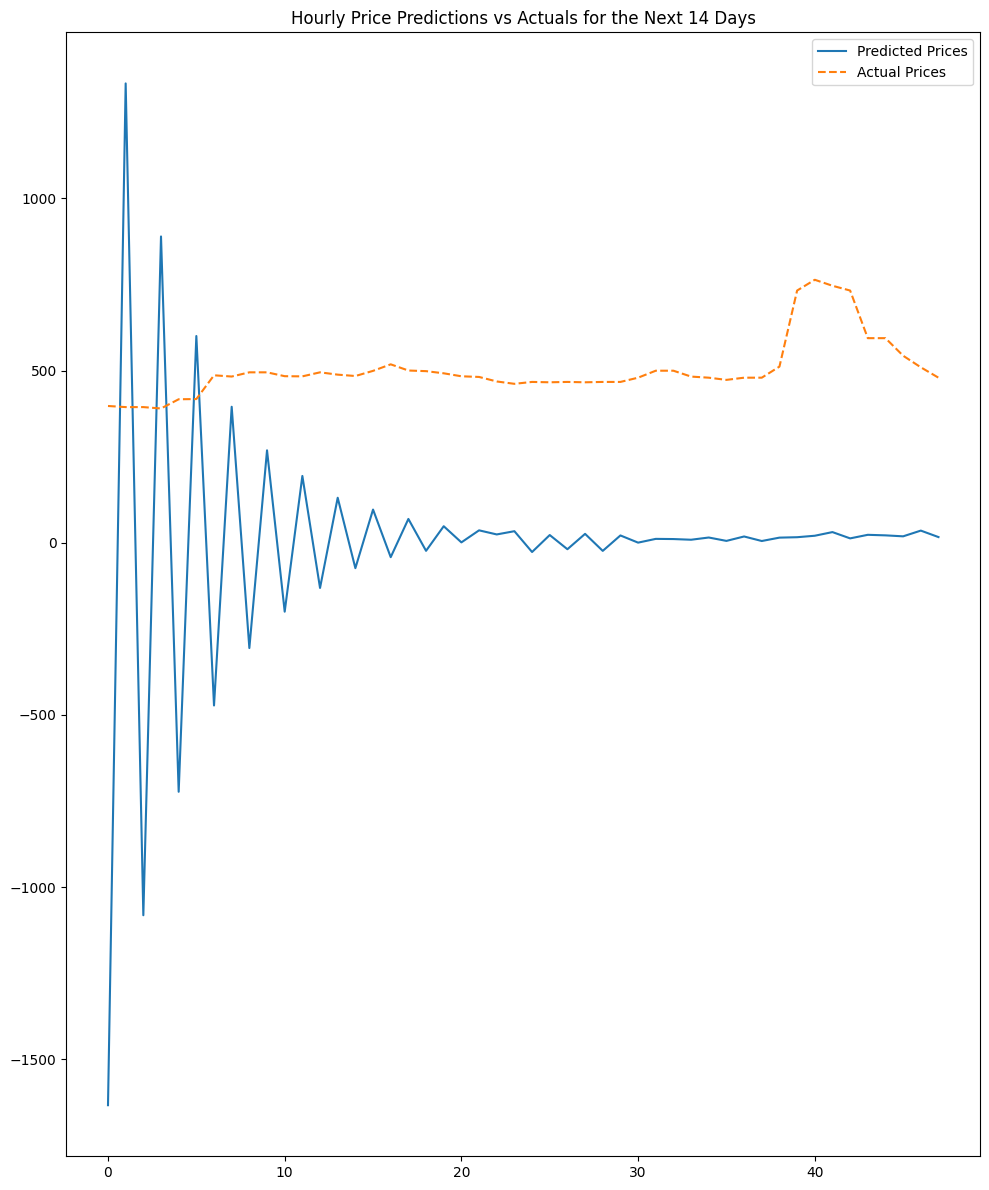

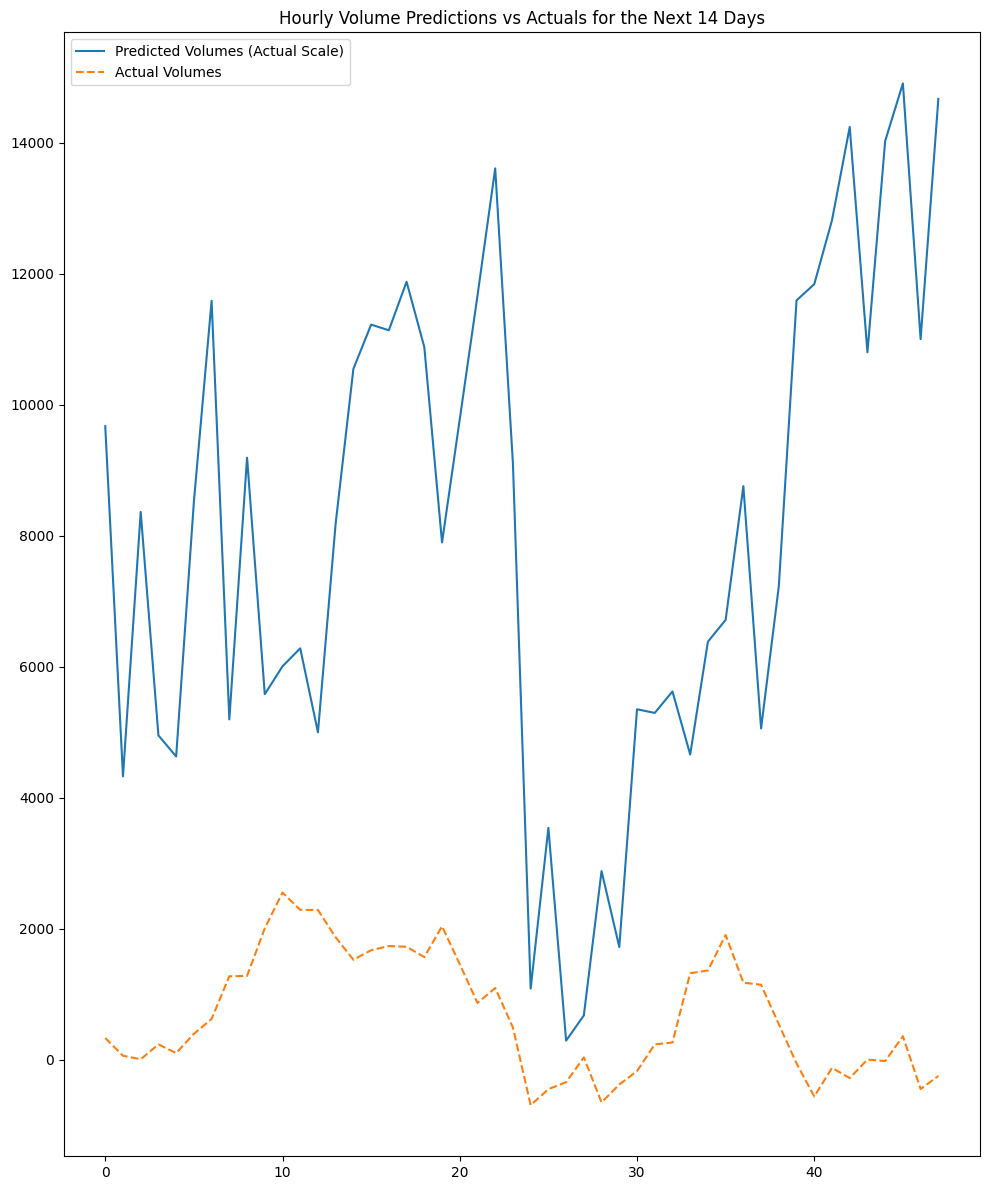

In [50]:

def generate_hourly_forecasts(X_test, hours_in_14_days, predictive_model, mcmc_samples):
    predictive = Predictive(model=predictive_model, posterior_samples=mcmc_samples)
    predicted_prices = []
    predicted_volumes = []
    current_input = X_test[0].copy()

    for hour in range(hours_in_14_days):
        key = jax.random.PRNGKey(hour)
        predictions = predictive(key, X=current_input.reshape(1, -1))
        print(f"Available keys in predictions: {list(predictions.keys())}")

        # price prediction
        if 'price_0' in predictions:
            print(f"Shape of price_0: {predictions['price_0'].shape}")
            print(f"Content of price_0: {predictions['price_0']}")
            if predictions['price_0'].ndim > 1:
                current_price_prediction = predictions['price_0'][0][0]
            else:
                current_price_prediction = predictions['price_0'][0]
            predicted_prices.append(current_price_prediction)
        else:
            print("Error: 'price_0' key not found in the predictions dictionary")

        # volume prediction
        if 'volume_0' in predictions:
            print(f"Shape of volume_0: {predictions['volume_0'].shape}")
            print(f"Content of volume_0: {predictions['volume_0']}")
            if predictions['volume_0'].ndim > 1:
                current_volume_prediction = predictions['volume_0'][0][0]
            else:
                current_volume_prediction = predictions['volume_0'][0]
            predicted_volumes.append(current_volume_prediction)
        else:
            print("Error: 'volume_0' key not found in the predictions dictionary")

        # update the input of next hour
        if hour + 1 < hours_in_14_days:
            next_input = X_test[hour + 1].copy()
            next_input[0] = current_price_prediction  
            current_input = next_input

    return predicted_prices, predicted_volumes

# using mcmc to predict
predicted_prices, predicted_volumes = generate_hourly_forecasts(X_test, hours_in_14_days, hmm_model, mcmc.get_samples())
y_test_actual = scaler_Y.inverse_transform(y_test)

fig, (ax1) = plt.subplots(1, 1, figsize=(10, 12))

# 价格预测与实际值对比
ax1.plot(predicted_prices, label='Predicted Prices')
ax1.plot(y_test_actual[:hours_in_14_days, 0], label='Actual Prices', linestyle='--')
ax1.set_title('Hourly Price Predictions vs Actuals for the Next 14 Days')
ax1.legend()

plt.tight_layout()
plt.show()
'''
# create an array
predicted_data = np.column_stack((predicted_prices, predicted_volumes))
'''
# Inversely normalize these predictions using the previously trained scaler_Y
predicted_data_actual = scaler_Y.inverse_transform(predicted_data)

# predicted_prices_actual = predicted_data_actual[:, 0]
predicted_volumes_actual = predicted_data_actual[:, 1]

# Assume that prediction has been made and predicted_data has been obtained
# Use the previously trained scaler_Y to inversely standardize these predicted values and actual test values
predicted_data_actual = scaler_Y.inverse_transform(predicted_data)
y_test_actual = scaler_Y.inverse_transform(y_test)

# Draw a comparison chart between the predicted value and the actual value after inverse normalization
fig, ( ax2) = plt.subplots(1, 1, figsize=(10, 12))


# compare them
ax2.plot(predicted_volumes_actual, label='Predicted Volumes (Actual Scale)')
ax2.plot(y_test_actual[:, 1], label='Actual Volumes', linestyle='--')
ax2.set_title('Hourly Volume Predictions vs Actuals for the Next 14 Days')
ax2.legend()

plt.tight_layout()
plt.show()


In [74]:
'''def generate_hourly_forecasts(X_test, hours_in_14_days, predictive_model, mcmc_samples, num_samples=100):
    predictive = Predictive(model=predictive_model, posterior_samples=mcmc_samples, num_samples=num_samples)
    predicted_prices = []
    predicted_volumes = []
    price_intervals = []
    volume_intervals = []

    current_input = X_test[0].copy()

    for hour in range(hours_in_14_days):
        key = jax.random.PRNGKey(hour)
        predictions = predictive(key, X=current_input.reshape(1, -1))

        # price prediction
        if 'price_0' in predictions:
            prices = predictions['price_0'].squeeze()
            mean_price = jnp.mean(prices)
            interval_price = jnp.percentile(prices, jnp.array([2.5, 97.5]))  # 使用 jnp.array 转换百分位数为 ndarray
            predicted_prices.append(mean_price)
            price_intervals.append(interval_price)
        else:
            print("Error: 'price_0' key not found in the predictions dictionary")

        # volume prediction
        if 'volume_0' in predictions:
            volumes = predictions['volume_0'].squeeze()
            mean_volume = jnp.mean(volumes)
            interval_volume = jnp.percentile(volumes, jnp.array([2.5, 97.5]))  # 使用 jnp.array 转换百分位数为 ndarray
            predicted_volumes.append(mean_volume)
            volume_intervals.append(interval_volume)
        else:
            print("Error: 'volume_0' key not found in the predictions dictionary")

        # update the input of next hour
        if hour + 1 < hours_in_14_days:
            next_input = X_test[hour + 1].copy()
            next_input[0] = mean_price  # Assuming first value is price
            current_input = next_input

    return predicted_prices, predicted_volumes, price_intervals, volume_intervals'''


C:\Users\admin\AppData\Local\Temp\ipykernel_11720\3370258341.py:2: UserWarning: Sample's batch dimension size 1000 is different from the provided 100 num_samples argument. Defaulting to 1000.
  predictive = Predictive(model=predictive_model, posterior_samples=mcmc_samples, num_samples=num_samples)


AttributeError: 'numpy.ndarray' object has no attribute 'plot'

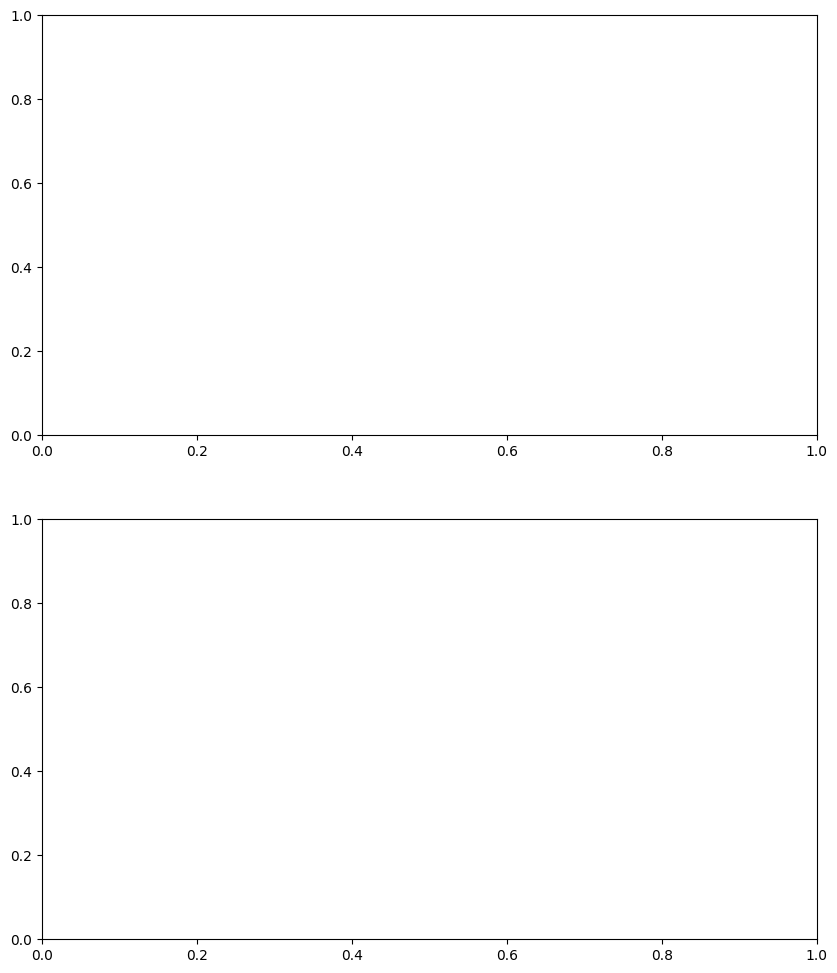

In [75]:
'''# 使用 mcmc 来进行预测
predicted_prices, predicted_volumes, price_intervals, volume_intervals = generate_hourly_forecasts(X_test, hours_in_14_days, hmm_model, mcmc.get_samples())
'''
# 逆向标准化数据和区间
predicted_data = np.column_stack((predicted_prices, predicted_volumes))
predicted_data_actual = scaler_Y.inverse_transform(predicted_data)
price_intervals_actual = scaler_Y.inverse_transform(np.array(price_intervals))
volume_intervals_actual = scaler_Y.inverse_transform(np.array(volume_intervals))
'''
fig, ( ax2) = plt.subplots(2, 1, figsize=(10, 12))


# 绘制交易量和交易量的置信区间
ax2.plot(predicted_data_actual[:, 1], label='Predicted Volumes')
ax2.fill_between(np.arange(len(volume_intervals_actual)),
                 volume_intervals_actual[:, 0], volume_intervals_actual[:, 1], color='green', alpha=0.2)
ax2.plot(y_test_actual[:hours_in_14_days, 1], label='Actual Volumes', linestyle='--')
ax2.set_title('Hourly Volume Predictions vs Actuals for the Next 14 Days')
ax2.legend()

plt.tight_layout()
plt.show()'''


In [38]:
'''# USE THE MODEL TO MAKE PREDICTIONS

# Make sure that X_test is a JAX array
X_test_jax = jnp.array(X_test)

# Create a Predictive object using the trained model and the MCMC samples
predictive = Predictive(model=hmm_model, posterior_samples=mcmc.get_samples())

# Generate predictions for the test set
predictions = predictive(jax.random.PRNGKey(1), X_test_jax, is_training=False)

# Print the keys of the predictions dictionary
print(predictions.keys())'''

'# USE THE MODEL TO MAKE PREDICTIONS\n\n# Make sure that X_test is a JAX array\nX_test_jax = jnp.array(X_test)\n\n# Create a Predictive object using the trained model and the MCMC samples\npredictive = Predictive(model=hmm_model, posterior_samples=mcmc.get_samples())\n\n# Generate predictions for the test set\npredictions = predictive(jax.random.PRNGKey(1), X_test_jax, is_training=False)\n\n# Print the keys of the predictions dictionary\nprint(predictions.keys())'

In [39]:
'''
# PLOT THE PREDICTED AND ACTUAL PRICES AND VOLUMES

# Extract the actual prices and volumes from the test set
y_test_actual_prices = y_test[:, 0]  # Prices on the balancing market
y_test_actual_volumes = y_test[:, 1]  # Imbalance volumes

# Extract the predicted prices and volumes from the predictions dictionary
predicted_prices = jnp.stack([predictions[f'price_{i}'] for i in range(len(y_test_actual_prices))])
predicted_volumes = jnp.stack([predictions[f'volume_{i}'] for i in range(len(y_test_actual_volumes))])

# Compute the mean of the predicted prices and volumes
mean_predicted_prices = jnp.mean(predicted_prices, axis=1)
mean_predicted_volumes = jnp.mean(predicted_volumes, axis=1)

# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot the comparison of predicted and actual prices 
axes[0].plot(mean_predicted_prices, label='Predicted Prices', color='blue')
axes[0].plot(y_test_actual_prices, label='Actual Prices', color='red', linestyle='dashed')
axes[0].set_title('Comparison of Predicted and Actual Prices')
axes[0].legend()

# Plot the comparison of predicted and actual volumes
axes[1].plot(mean_predicted_volumes, label='Predicted Volumes', color='blue')
axes[1].plot(y_test_actual_volumes, label='Actual Volumes', color='red', linestyle='dashed')
axes[1].set_title('Comparison of Predicted and Actual Volumes')
axes[1].legend()

# Display the plots
plt.tight_layout()
plt.show()
'''

"\n# PLOT THE PREDICTED AND ACTUAL PRICES AND VOLUMES\n\n# Extract the actual prices and volumes from the test set\ny_test_actual_prices = y_test[:, 0]  # Prices on the balancing market\ny_test_actual_volumes = y_test[:, 1]  # Imbalance volumes\n\n# Extract the predicted prices and volumes from the predictions dictionary\npredicted_prices = jnp.stack([predictions[f'price_{i}'] for i in range(len(y_test_actual_prices))])\npredicted_volumes = jnp.stack([predictions[f'volume_{i}'] for i in range(len(y_test_actual_volumes))])\n\n# Compute the mean of the predicted prices and volumes\nmean_predicted_prices = jnp.mean(predicted_prices, axis=1)\nmean_predicted_volumes = jnp.mean(predicted_volumes, axis=1)\n\n# Create a figure with two subplots\nfig, axes = plt.subplots(2, 1, figsize=(14, 10))\n\n# Plot the comparison of predicted and actual prices \naxes[0].plot(mean_predicted_prices, label='Predicted Prices', color='blue')\naxes[0].plot(y_test_actual_prices, label='Actual Prices', color='red